In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [12]:
# Load Data
news_data = pd.read_csv('data/news_articles.csv')

# Preprocess Data
news_data = news_data.drop(columns=['author', 'published', 'text', 'language', 'main_img_url', 'type', 'title_without_stopwords', 'text_without_stopwords', 'hasImage'], errors='ignore')
news_data = news_data[news_data['label'].apply(lambda x: isinstance(x, str))]  
news_data['label'] = news_data['label'].apply(lambda x: 1 if x.lower() == 'fake' else 0)
news_data.dropna(subset=['title'], inplace=True)

In [13]:
# Vectorize Titles using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
title_features_vectorized = vectorizer.fit_transform(news_data['title']).toarray()

# Feature Scaling
scaler = StandardScaler()
title_features_vectorized = scaler.fit_transform(title_features_vectorized)

# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
title_features_resampled, labels_resampled = smote.fit_resample(title_features_vectorized, news_data['label'])

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    title_features_resampled, labels_resampled, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_texts = torch.tensor(train_texts, dtype=torch.float32)
test_texts = torch.tensor(test_texts, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels.to_numpy(), dtype=torch.long) 

C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [14]:
# Define Dataset Class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create DataLoaders
train_dataset = FakeNewsDataset(train_texts, train_labels)
test_dataset = FakeNewsDataset(test_texts, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=16)

# Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional LSTM, hence 2x hidden_dim
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        lstm_out, _ = self.lstm(x)
        lstm_out = self.relu(lstm_out[:, -1, :])  # Take the last hidden state
        return self.fc(lstm_out)

# Initialize Model
input_dim = 5000
hidden_dim = 128
output_dim = 2
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
# Train Model
def train_model(model, train_dataloader, eval_dataloader, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for texts, labels in tqdm(train_dataloader):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader)}")

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for texts, labels in eval_dataloader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        print(f"Validation Accuracy: {correct / total:.4f}")

# Train the Model
num_epochs = 5
train_model(model, train_dataloader, eval_dataloader, num_epochs, device)

# Save Model
torch.save(model.state_dict(), "fake_news_lstm.pth")
print("Model saved as fake_news_lstm.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.40it/s]


Epoch 1/5, Loss: 0.6877614424778865
Validation Accuracy: 0.6486


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.45it/s]


Epoch 2/5, Loss: 0.6569081343137301
Validation Accuracy: 0.7432


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.99it/s]


Epoch 3/5, Loss: 0.5751838280604435
Validation Accuracy: 0.7587


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.46it/s]


Epoch 4/5, Loss: 0.38272971018002583
Validation Accuracy: 0.7336


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.69it/s]


Epoch 5/5, Loss: 0.1771299536125018
Validation Accuracy: 0.7336
Model saved as fake_news_lstm.pth


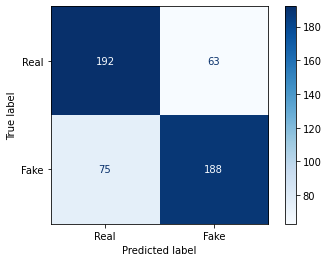

Accuracy: 0.7335907335907336
              precision    recall  f1-score   support

        Real       0.72      0.75      0.74       255
        Fake       0.75      0.71      0.73       263

    accuracy                           0.73       518
   macro avg       0.73      0.73      0.73       518
weighted avg       0.73      0.73      0.73       518



In [16]:
# Evaluate Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for texts, labels in eval_dataloader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute Evaluation Metrics
conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=['Real', 'Fake']))